# SST

SSt data from copernicus
https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=SST_GLO_SST_L3S_NRT_OBSERVATIONS_010_010

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_name = "data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_1624627070975.nc"
ds_SST = xr.open_dataset(file_name)

In [4]:
ds_SST = ds_SST.resample(time = "1D").mean(keep_attrs=True);

# Functions

In [5]:
def MHW_func (data, climP=[2014.0,2021.0], altClim=False):
    yy_start = int(data.time[0].dt.year)
    yy_end = int(data.time[-1].dt.year)
    mm_start = int(data.time[0].dt.month)
    mm_end = int(data.time[-1].dt.month)
    dd_start = int(data.time[0].dt.day)
    dd_end = int(data.time[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 # .toordinal turns the date into a number that the algorithm can process
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.analysed_sst.squeeze().values   # by using .squeeze().values we are first removing any other depth and then turning the data into a 1d numpy array 
                                                                        # without doing this the data will still be in an array and the algorithm can't handle it
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)                                    # using the algorithm
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)            # cold spells 
    return mhws, mcss, clim, clim_cold, t, temp  

In [6]:
def DICT_func(data, n, climP=[2014,2020], altClim= False, altT=False, altData=False):  
    # define 6 empty dictionaries
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}

    # Iterating through all instrument depths       
    #for n in depth:

    mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, climP=climP, altClim=altClim)
    mhws_.update({str(n):mhws})
    mcss_.update({str(n):mcss})
    clim_.update({str(n):clim})
    clim_cold_.update({str(n):clim_cold})
    t_.update({str(n):t})
    temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [30]:
def ALL_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]

    ev = (mhws['n_events'])
    ec = (mcss['n_events'])


    plt.figure(figsize=(30,15))
    plt.subplot(2,1,1)

    # Plot t, seasonal cycle, and threshold
    plt.plot(dates, clim['thresh'], ':r', label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', label = 'Threshold cold')
    plt.plot(dates, temp, 'k', label = 'Temperature', linewidth = .75)
    plt.plot(dates, clim['seas'], 'b', label = 'Climatology')
    plt.legend()
    plt.title('Data Overview')
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(date(2016,1,1), date(2017,5,1))
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.ylabel(r't $^\circ$C')
    plt.grid()

    # plt the heatwaves
    plt.subplot(2,1,2)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                         color='pink')

    # Find MHW of interest and shade accordingly
    ev_i = np.argmax(mhws['intensity_max'])
    t1 = np.where(t==mhws['time_start'][ev_i])[0][0]
    t2 = np.where(t==mhws['time_end'][ev_i])[0][0]
    plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color='deeppink', label = 'MHW event with max intensity')


    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                         color='cyan')

    # Find MCSS of interest and shade accordingly
    ec_i = np.argmin(mcss['intensity_max'])
    tc1 = np.where(t==mcss['time_start'][ec_i])[0][0]
    tc2 = np.where(t==mcss['time_end'][ec_i])[0][0]
    plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                     color='darkcyan', label = 'MCSS event with max intensity')    

    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=2, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=2, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.75, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=2, label = 'Climatology')
    plt.legend()
    plt.title('Marine Heatwaves and Cold Spells')
    #plt.xlim(date(2014,7,18), date(2020,10,20))
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(mhws['date_start'][ev-12], mhws['date_end'][ev+4])
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.grid()
    plt.ylabel(r't $^\circ$C');
    
    #print some intersting stats
    print('Overview:')
    print('Number of MHWs: ', ev)
    print('Number of MCSs: ', ec)
    print('The MHWs of max intensity lastet from the', mhws['date_start'][ev_i], 'to the', mhws['date_end'][ev_i])
    print('The MCSs of max intensity lastet from the', mcss['date_start'][ec_i], 'to the', mcss['date_end'][ec_i])
    print(' ')

#plt.savefig('100m_EAST_zoom_2016-2017', dpi = 300)

# make EB and WB subsets

In [32]:
ds_SST

<xarray.Dataset>
Dimensions:       (depth: 1, lat: 141, lon: 201, time: 2673)
Coordinates:
  * time          (time) datetime64[ns] 2014-03-01 2014-03-02 ... 2021-06-24
  * lon           (lon) float32 -18.02 -17.98 -17.92 ... -8.125 -8.075 -8.025
  * lat           (lat) float32 52.97 53.03 53.08 53.12 ... 59.88 59.92 59.97
  * depth         (depth) float64 0.0
Data variables:
    analysed_sst  (depth, time, lat, lon) float32 283.0 283.0 ... 283.7 283.7
Attributes: (12/48)
    Conventions:                                    CF-1.4, ACDD-1.3
    title:                                          Global SST & Sea Ice Anal...
    summary:                                        A merged, multi-sensor L4...
    references:                                     Good S, Fiedler E, Mao C,...
    institution:                                    UKMO
    history:                                        Created from sst.nc; obs_...
    ...                                             ...
    publisher_name:                                 GHRSST Project Office
    publisher_url:                                  http://www.ghrsst.org
    publisher_email:                                ghrsst-po@nceo.ac.uk
    processing_level:                               L4
    cdm_data_type:                                  grid
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

In [8]:
ds_SST.coords['depth'] = float(0)

In [9]:
depth = 1
ds_SST = ds_SST.expand_dims({"depth":depth})

In [33]:
SST_EB = ds_SST.sel(lat = slice(56.5, 57.5), lon = slice(-10, -9))
SST_EB = SST_EB.mean(dim = ('lat', 'lon'))


In [34]:
SST_EB

<xarray.Dataset>
Dimensions:       (depth: 1, time: 2673)
Coordinates:
  * time          (time) datetime64[ns] 2014-03-01 2014-03-02 ... 2021-06-24
  * depth         (depth) float64 0.0
Data variables:
    analysed_sst  (depth, time) float32 282.3 282.3 282.3 ... 285.3 285.1 285.2

In [11]:
SST_WB = ds_SST.sel(lat = slice(57, 58), lon = slice(-12, -13))
SST_WB = SST_WB.mean(dim = 'lat')
SST_WB = SST_WB.mean(dim = 'lon')

In [12]:
EB = DICT_func(SST_EB, 0)
WB = DICT_func(SST_WB, 0)

Overview:
Number of MHWs:  9
Number of MCSs:  13
The MHWs of max intensity lastet from the 2014-07-20 to the 2014-07-28
The MCSs of max intensity lastet from the 2015-06-14 to the 2015-06-29
 


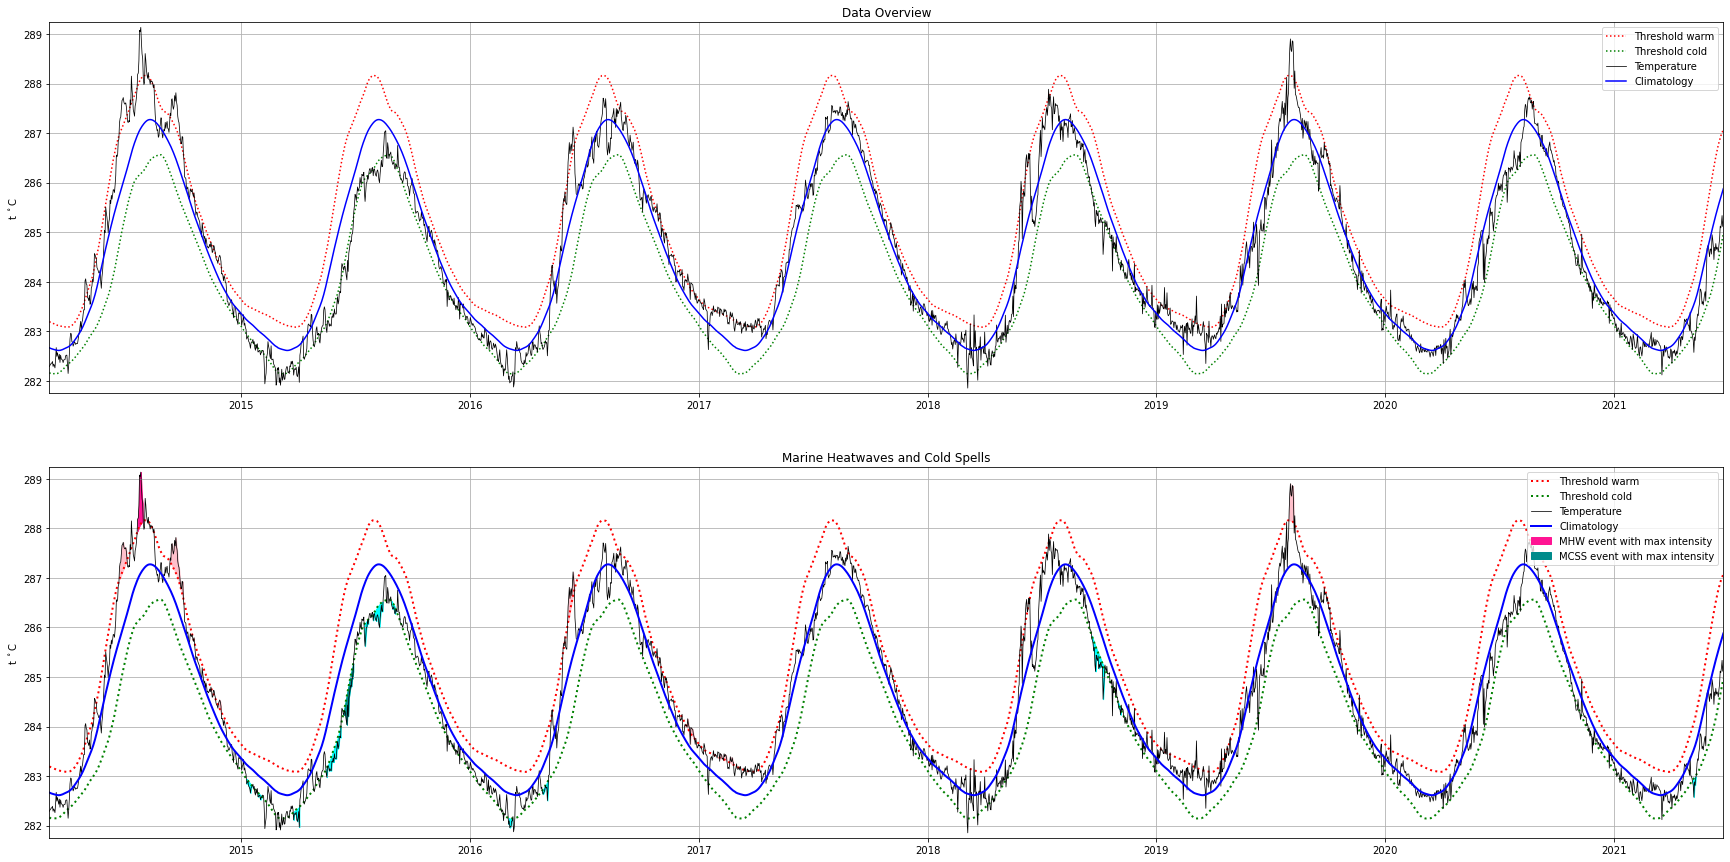

In [31]:
ALL_events(EB, 0)

In [25]:
WB

{'mhws': {'0': {'time_start': [],
   'time_end': [],
   'time_peak': [],
   'date_start': [],
   'date_end': [],
   'date_peak': [],
   'index_start': [],
   'index_end': [],
   'index_peak': [],
   'duration': [],
   'duration_moderate': [],
   'duration_strong': [],
   'duration_severe': [],
   'duration_extreme': [],
   'intensity_max': [],
   'intensity_mean': [],
   'intensity_var': [],
   'intensity_cumulative': [],
   'intensity_max_relThresh': [],
   'intensity_mean_relThresh': [],
   'intensity_var_relThresh': [],
   'intensity_cumulative_relThresh': [],
   'intensity_max_abs': [],
   'intensity_mean_abs': [],
   'intensity_var_abs': [],
   'intensity_cumulative_abs': [],
   'category': [],
   'rate_onset': [],
   'rate_decline': [],
   'n_events': 0}},
 'mcss': {'0': {'time_start': [],
   'time_end': [],
   'time_peak': [],
   'date_start': [],
   'date_end': [],
   'date_peak': [],
   'index_start': [],
   'index_end': [],
   'index_peak': [],
   'duration': [],
   'duration

In [26]:
# cannot find heatwaves if there are none...
# ALL_events(WB, 0)